# Evaluating Llama 2 70b Chat - multilabel

In [1]:
import random
import sys
sys.path.append('..')
import pandas as pd
from src.api import API
from src.dataloader import DataLoader
from src.prompter import prompter_factory
from src.scorer import scorer_factory
from src.scorer import compare_models_bootstrap
from dotenv import load_dotenv
load_dotenv()
import os

In [2]:
TOGETHER_API_KEY = os.getenv("API_KEY")
BASE_URL = "https://api.together.xyz"

In [3]:
api = API(api_key=TOGETHER_API_KEY, base_url=BASE_URL)
client = api.get_openai()

In [4]:
dataloader = DataLoader(path="../data/")
data = dataloader.get_standardized_dataframe(context_col="Text Data",
                                             target_binary_col="symptom_status_gs",
                                             target_multilabel_col="symptom_detail_gs",
                                             keep_other_cols=True)

In [5]:
Llama2_70B_Chat = prompter_factory(prompter_type="multilabel",
                                   client=client,
                                   model="meta-llama/Llama-2-70b-chat-hf")

In [6]:
# credits to https://www.reddit.com/r/LocalLLaMA/comments/15742zf/comment/jt4ag66/?utm_source=share&utm_medium=web3x&utm_name=web3xcss&utm_term=1&utm_content=share_button
prompt = """
You are a helpful assistant, that only communicates using JSON files. Thex expected output from you has to be a JSON file with the following structure:

{
    "Anxiety": bool (True or False),
    "Concentration_Problems": bool (True or False),
    "Constipation": bool (True or False),
    "Cough": bool (True or False),
    "Diarrhea": bool (True or False),
    "Fatigue": bool (True or False),
    "Fever": bool (True or False),
    "Headache": bool (True or False),
    "Nausea": bool (True or False),
    "Numbness_and_Tingling": bool (True or False),
    "Pain": bool (True or False),
    "Poor_Appetite": bool (True or False),
    "Rash": bool (True or False),
    "Shortness_of_Breath": bool (True or False),
    "Trouble_Drinking_Fluids": bool (True or False),
    "Vomiting": bool (True or False),
    "Other": bool (True or False)
}

Given a transcript, you have to return a JSON file with the presence of each symptom in the transcript. 
For instance, given the following transcript: 'D: And are you feeling better? P: No, I'm not. I'm still 
not very hungry and need to sleep all the time.' you should return:

{
    "Anxiety": false,
    "Concentration_Problems": false,
    "Constipation": false,
    "Cough": false,
    "Diarrhea": false,
    "Fatigue": true,
    "Fever": false,
    "Headache": false,
    "Nausea": false,
    "Numbness_and_Tingling": false,
    "Pain": false,
    "Poor_Appetite": true,
    "Rash": false,
    "Shortness_of_Breath": false,
    "Trouble_Drinking_Fluids": false,
    "Vomiting": false,
    "Other": false
}
"""

In [7]:
results_llama2_70B_chat = Llama2_70B_Chat.generate(df=data, prompt=prompt)

multilabel task using: meta-llama/Llama-2-70b-chat-hf - Total tokens: 0:   0%|          | 0/550 [00:00<?, ?it/s]

multilabel task using: meta-llama/Llama-2-70b-chat-hf - Total tokens: 491,375: 100%|██████████| 550/550 [00:41<00:00, 13.33it/s]


## Model evaluation

Bootstrapping Llama2_70B_Chat: 100%|██████████| 1000/1000 [00:09<00:00, 103.80it/s]


accuracy: 0.3656 (0.326-0.4022 95% CI)
precision: 0.6998 (0.6575-0.7424 95% CI)
recall: 0.4125 (0.3777-0.4488 95% CI)
f1: 0.5188 (0.4872-0.5496 95% CI)
Unstructured output ratio: 0.009 (0.0018-0.0182 95% CI)


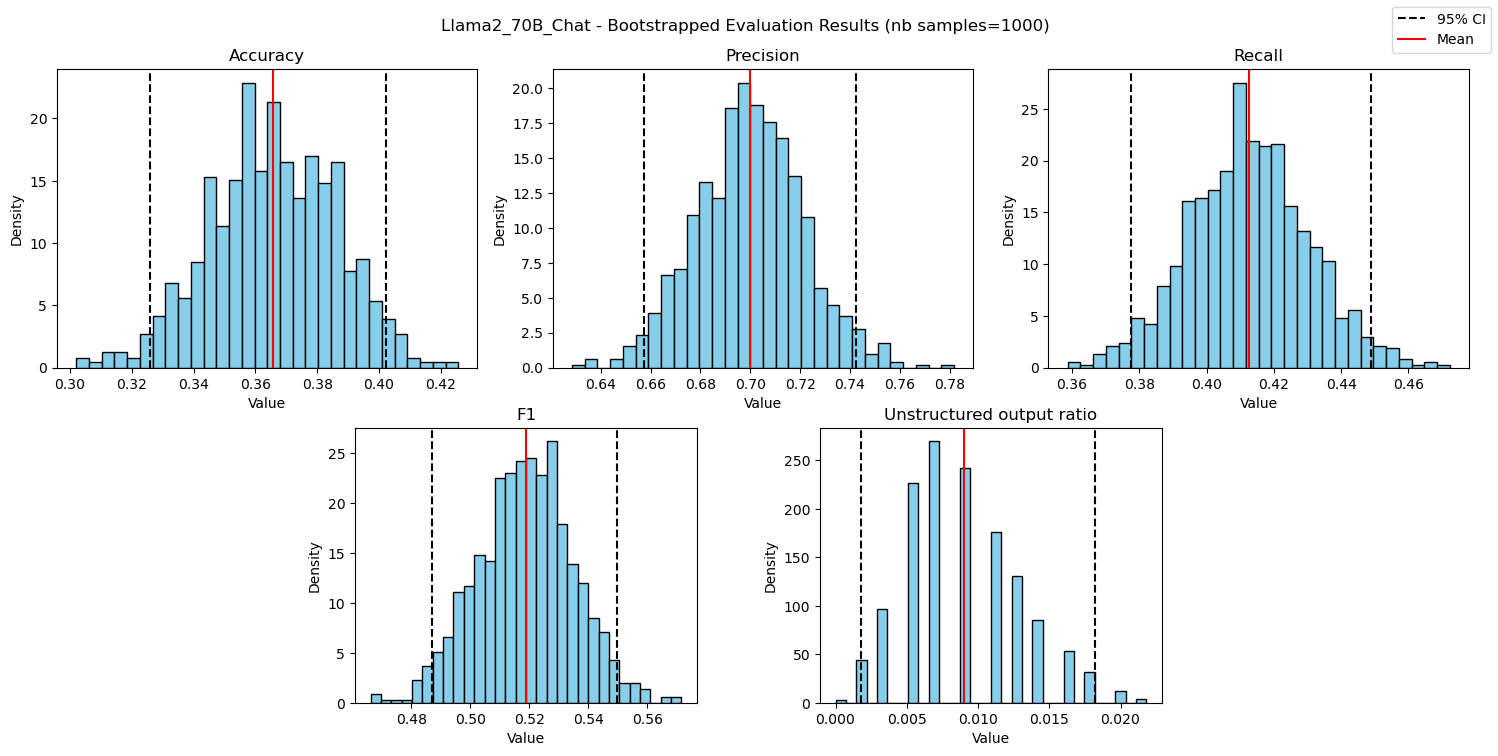

In [10]:
scorer_llama2_70B_chat = scorer_factory(scorer_type="multilabel", data=data, results=results_llama2_70B_chat, model_name="Llama2_70B_Chat")
scorer_llama2_70B_chat.display_bootstrap_results(sample_size=len(data), output_type="both", n_samples=1000)

multilabel task using: mistralai/Mistral-7B-Instruct-v0.1 - Total tokens: 16,439: 100%|██████████| 550/550 [11:14<00:00,  1.23s/it]  
multilabel task using: mistralai/Mixtral-8x7B-Instruct-v0.1 - Total tokens: 279,926: 100%|██████████| 550/550 [26:30<00:00,  2.89s/it]  
Bootstrapping Llama2_70B_Chat: 100%|██████████| 1000/1000 [00:09<00:00, 101.93it/s]


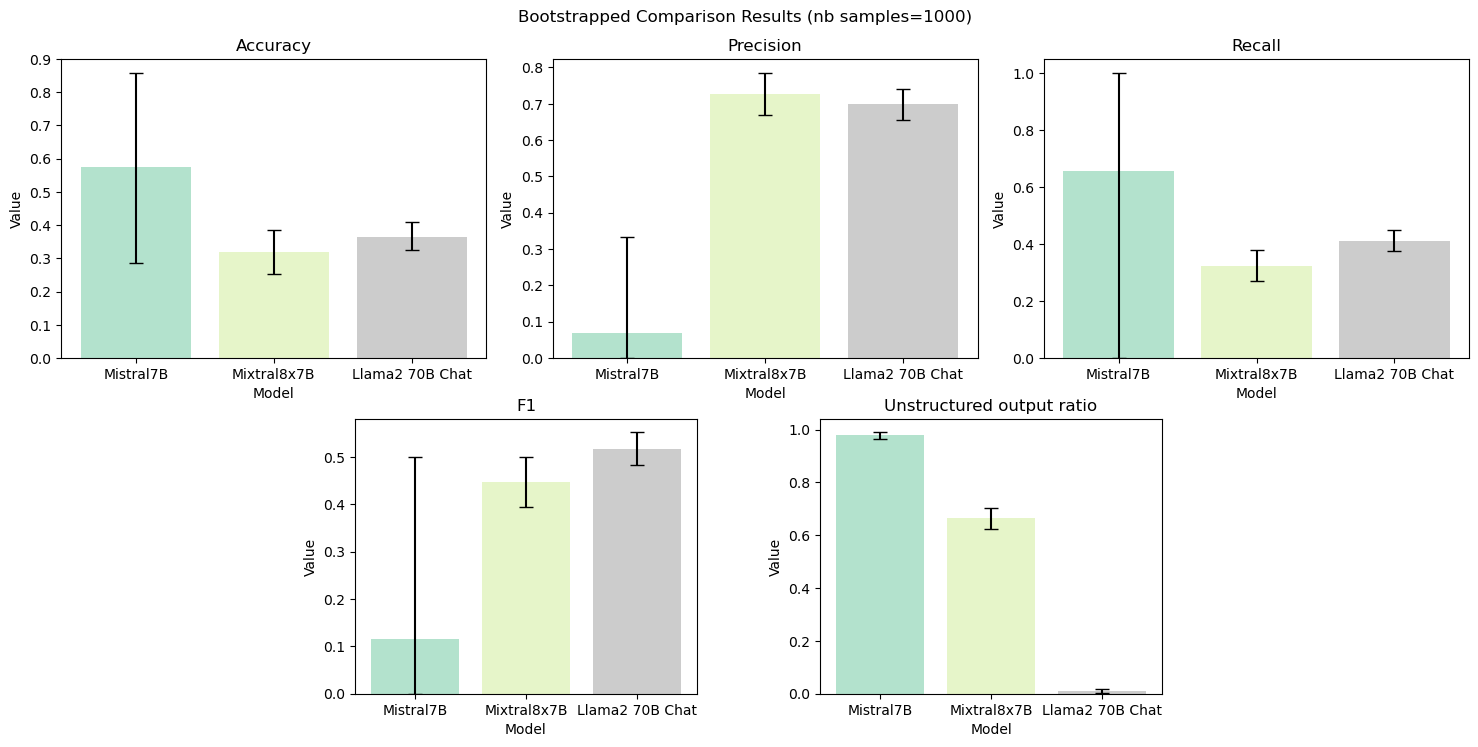

In [17]:
Mistral7B = prompter_factory(prompter_type="multilabel",
                             client=client,
                             model="mistralai/Mistral-7B-Instruct-v0.1")
results_mistral7b = Mistral7B.generate(df=data, prompt=prompt)
scorer_mistral7b = scorer_factory(scorer_type="multilabel", data=data, results=results_mistral7b, model_name="Mistral7B")

Mixtral8x7B = prompter_factory(prompter_type="multilabel",
                               client=client,
                               model="mistralai/Mixtral-8x7B-Instruct-v0.1")
results_mixtral8x7b = Mixtral8x7B.generate(df=data, prompt=prompt)
scorer_mixtral8x7b = scorer_factory(scorer_type="multilabel", data=data, results=results_mixtral8x7b, model_name="Mixtral8x7B")

dict_scorers = {"Mistral7B": scorer_mistral7b, "Mixtral8x7B": scorer_mixtral8x7b, "Llama2 70B Chat": scorer_llama2_70B_chat}
compare_models_bootstrap(dict_scorers=dict_scorers, sample_size=len(data), n_samples=1000)

## Error Interrogation

In [18]:
df_llama2_70B_chat_error = scorer_llama2_70B_chat.get_error_dataframe()

In [20]:
selected_columns = df_llama2_70B_chat_error.columns[:df_llama2_70B_chat_error.columns.get_loc("Target binary")].to_list() + scorer_mistral7b.pred_columns.to_list() + scorer_mistral7b.target_columns.to_list()
df_llama2_70B_chat_error[selected_columns].describe()

,Context,Symptom Status_bd,Detailed Choices_bd,Source_x,Symptom Status_CVD,Detailed Choices_CVD,Source_y,Differences,Adjudication Decision,Pres_Abs_Diffs,...,Target headache,Target nausea,Target numbness and tingling,Target pain,Target poor appetite,Target rash,Target shortness of breath,Target trouble drinking fluids,Target vomiting,Target other
count,351,173,150,351,351,305,351,102,102,14,...,351,351,351,351,351,351,351,351,351,351
unique,351,2,86,50,2,131,50,26,63,2,...,2,2,2,2,2,2,2,2,2,2
top,"D: How may I help you?\n\nP: Hi, umm, so I've ...",Positive,Other,RES0022.txt,Positive,Other,RES0022.txt,Other,pain,Negative;Positive,...,False,False,False,False,False,False,False,False,False,True
freq,1,149,14,13,305,32,13,26,7,11,...,306,313,328,203,324,316,274,349,312,263


In [23]:
df_llama2_70B_chat_error.loc[:, "Concatenated"] = df_llama2_70B_chat_error.apply(
    lambda row: f"index: {row.name}\n\nContext: {row['Context']}\n\n\nModel Prediction:\n{row[scorer_mistral7b.pred_columns]}",
    axis=1
)
# Converting to a list makes for an easier way to print the results
contexts_llama2_70B_chat = df_llama2_70B_chat_error["Concatenated"].to_list()

In [24]:
random.shuffle(contexts_llama2_70B_chat)
print(contexts_llama2_70B_chat[0])

index: 197

Context: P: Yeah, sometimes I'll have a glass of wine on the weekend or something like that, but that will just be one or two, maybe with dinner.

D: OK. And have you been in contact with anyone sick recently?

P: No, I I don't think so. I mean, I've been working from well, some days I've had to go into the office for work, but I've been mostly just working from, from home.

D: OK. OK. Uhm and where do you live right now?

P: So I live in a house downtown in the city here and I live with my wife and our two sons. 

D: OK, any are they, they're ok, they're all healthy?

P: Uhm, yeah they they, they uh, well my son actually had a cough and a sore throat I think like last week or something like that but it just went it went away.


Model Prediction:
Pred Anxiety                    False
Pred Concentration_Problems     False
Pred Constipation               False
Pred Cough                       True
Pred Diarrhea                   False
Pred Fatigue                    False
Pre

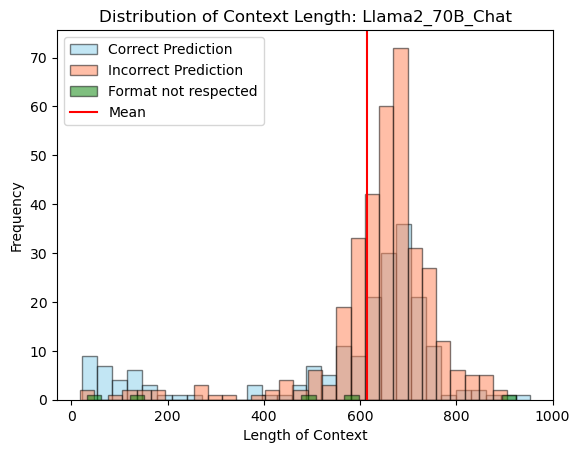

In [26]:
scorer_llama2_70B_chat.display_length_distribution()